In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
from PIL import Image

# 1-Data

In [3]:
alpha_data=pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")
digit_data=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [4]:
alpha_data.describe()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
count,372450.000000,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,...,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000
mean,13.523490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001616,0.001592,0.001117,0.000929,0.000685,0.000596,0.000618,0.000690,0.000239,0.000011
std,6.740824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490788,0.517297,0.421332,0.419180,0.385566,0.319820,0.208942,0.335227,0.134852,0.006554
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,252.000000,226.000000,229.000000,228.000000,235.000000,194.000000,103.000000,198.000000,82.000000,4.000000


In [5]:
alpha_pixels=alpha_data.drop("0",axis=1)
alpha_labels=np.array(alpha_data["0"])
digit_pixels=digit_data.drop("label",axis=1)
digit_labels=np.array(digit_data["label"])+26

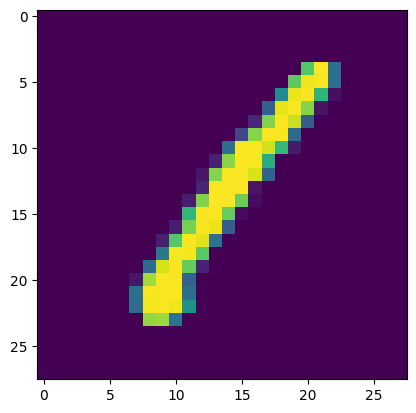

In [6]:
plt.imshow(np.array(digit_pixels.iloc[0]).reshape((28,28)))

In [7]:
image=alpha_pixels.iloc[0]
image=np.array(image)
image=image.reshape((28,28))

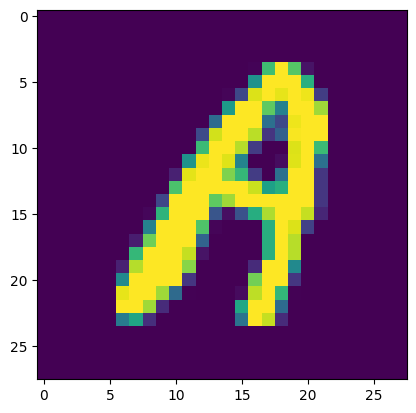

In [8]:
plt.imshow(image)

In [9]:
np.random.seed(300)

In [10]:
state=np.random.get_state()

In [11]:
alpha_pixels=np.array(alpha_pixels)
digit_pixels=np.array(digit_pixels)

In [12]:
pixels=np.concatenate((alpha_pixels,digit_pixels),axis=0)
labels=np.concatenate((alpha_labels,digit_labels))
labels=labels.reshape((-1,1))
pixels_with_lab=np.concatenate((pixels,labels),axis=1)

In [13]:
np.random.seed(300)
np.random.set_state(state)
np.random.shuffle(pixels_with_lab)

In [14]:
pixels=pixels_with_lab[:,:-1]
labels=pixels_with_lab[:,-1]

Text(0.5, 1.0, '27')

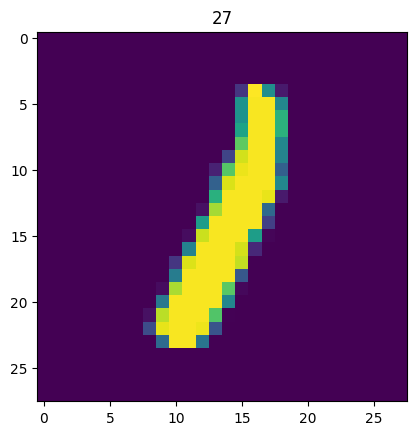

In [15]:
plt.imshow(pixels[5].reshape((28,28)))
plt.title(labels[5])
    

In [16]:
classes=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','0','1','2','3','4','5','6','7','8','9']

#### a-Creating a class encoder

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
classes_to_encode=np.array([[i] for i in range(len(classes))])

In [19]:
encoder=OneHotEncoder().fit(classes_to_encode)

In [20]:
encoder.transform([[0],[23]]).toarray()[1].shape

(36,)

In [21]:
from torchvision.transforms.functional import pil_to_tensor,to_pil_image

In [22]:
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn

In [23]:
Image.fromarray(pixels[0].reshape((28,28)).astype('uint8'))

In [24]:
class Char_dataset(Dataset):
    def __init__(self):
        self.data=pixels
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        img_array=self.data[index].reshape((28,28)).astype('uint8')
        image=Image.fromarray(img_array)
        image=pil_to_tensor(image)
        label=self.labels[index]
        label=encoder.transform([[label]]).toarray() #one hot encoded label
        return image/255,label[0] #to get the vector of label because label is a nested list

# 2-Models and Training

In [25]:
input_size=136
batch_size=128
n_epochs=60
device="cuda" if torch.cuda.is_available() else "cpu"

In [26]:
char_data=Char_dataset()
char_loader=DataLoader(dataset=char_data,batch_size=batch_size,shuffle=True)

In [27]:
import torch.optim as optim

#### a-Creating a Generator and a Discriminator

In [28]:
discriminator=nn.Sequential(#nn.Conv2d(1,1,3),
                            nn.Conv2d(1,1,kernel_size=(3, 3), padding=(1, 1)),#because i had a problem that the layer before was reducing shape
                            nn.Flatten(),
                            nn.Linear(28*29,1024),
                            #nn.BatchNorm1d(1024),
                            nn.LayerNorm(1024),
                            nn.ReLU(),
                            #nn.Linear(1024,1024),
                            #nn.ReLU(),
                            nn.Dropout(p=0.4),
                            nn.Linear(1024,256),
                            nn.LayerNorm(256),
                            nn.LeakyReLU(),
                            #nn.BatchNorm1d(256),
                            nn.Linear(256,1),
                            nn.Sigmoid())
#class Discriminator(nn.Module)
discriminator=discriminator.to(device)

In [29]:
"""generator = nn.Sequential(
    nn.Linear(input_size, 512*7*7),
    nn.Unflatten(1, (512, 7, 7)),
    nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=1, padding=1),
    nn.Sigmoid()
)"""
#generator using FC layers
generator=nn.Sequential(
    nn.Linear(input_size, 2048),
    nn.Linear(2048,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Linear(1024,800),
    nn.BatchNorm1d(800),
    nn.LeakyReLU(),
    nn.Linear(800,28*28),
    nn.Unflatten(1,(1,28,28)),
    nn.Sigmoid()
)   

generator=generator.to(device)

In [30]:
generator.state_dict()
data={"generator_dict":generator.state_dict()}
torch.save(data,"data.pth")

In [31]:
noise=np.random.randn(2,100)
images_class=encoder.transform([[0],[23]]).toarray()
image_array=generator(torch.from_numpy(np.concatenate((noise,images_class),axis=1)).float().to(device)).detach().to('cpu').numpy()

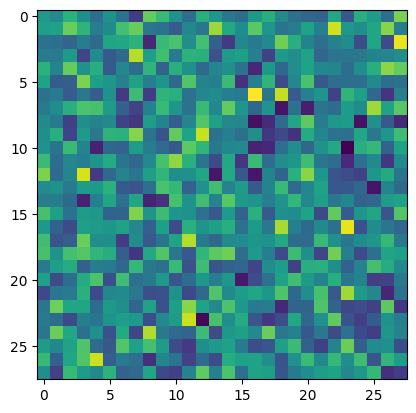

In [32]:
plt.imshow(image_array[0][0])

In [33]:
criterion=nn.BCELoss()

In [34]:
disc_optimizer=optim.Adam(params=discriminator.parameters(),lr=0.0005)
gen_optimizer=optim.Adam(params=generator.parameters(),lr=0.001)

#### b-training loop

discriminator loss 0.2327040094074605 for 1/60
generator loss 5.736964184093652 for 1/60


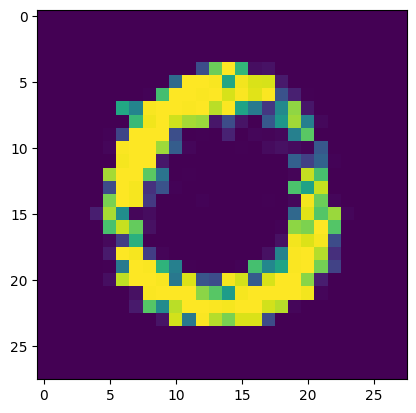

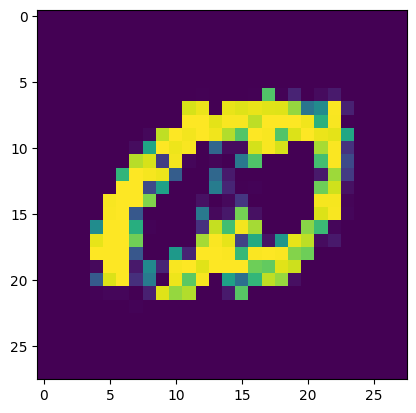

discriminator loss 0.36106126315067993 for 2/60
generator loss 3.1479521273756705 for 2/60


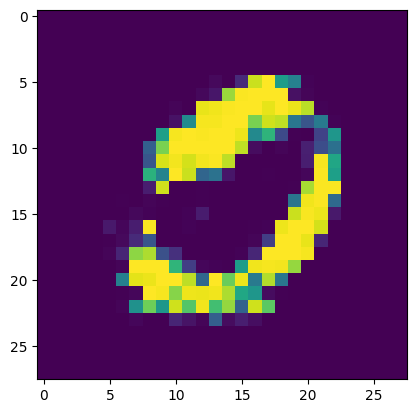

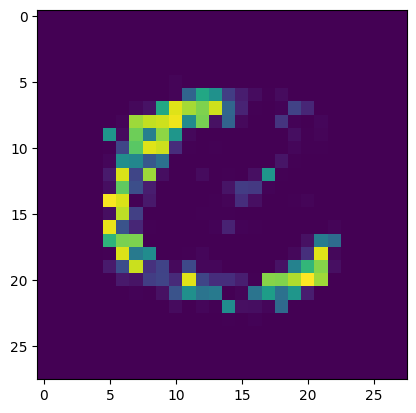

discriminator loss 0.46132555863992014 for 3/60
generator loss 2.098520899091406 for 3/60


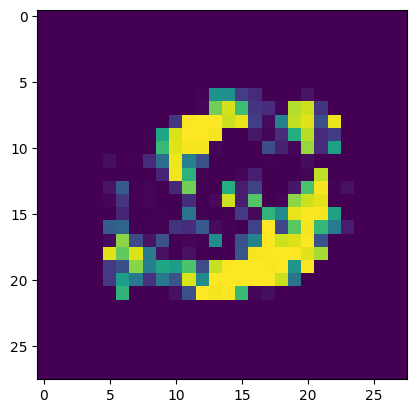

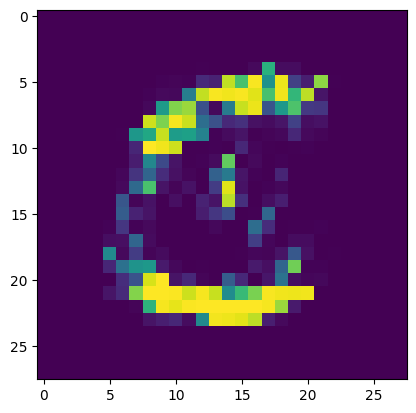

discriminator loss 0.5258760156916423 for 4/60
generator loss 1.6408182752581568 for 4/60


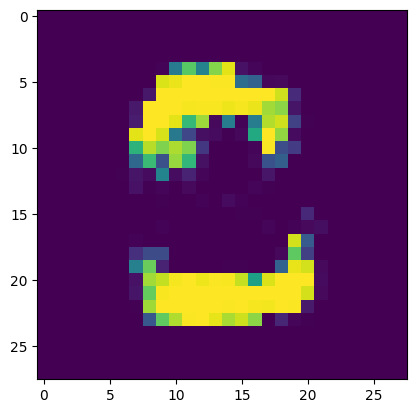

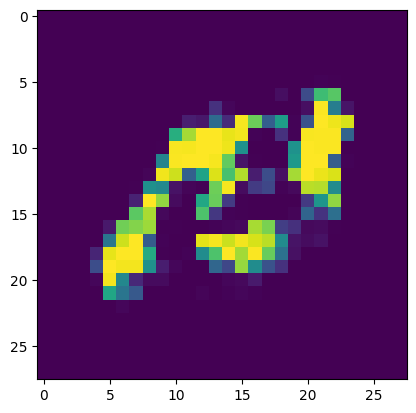

discriminator loss 0.5785439463678593 for 5/60
generator loss 1.350564867644637 for 5/60


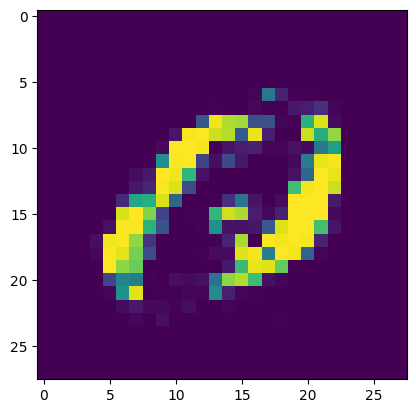

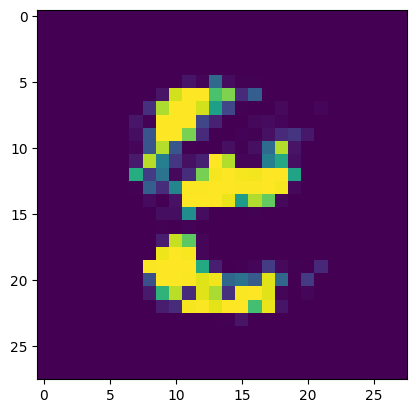

discriminator loss 0.6143843755356098 for 6/60
generator loss 1.1532622184592902 for 6/60


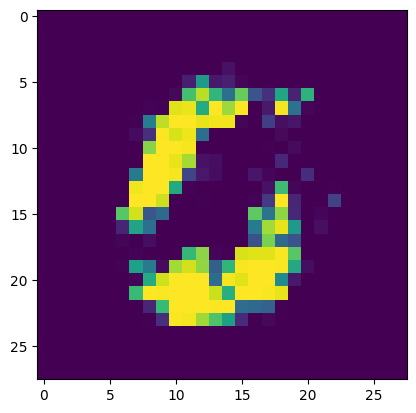

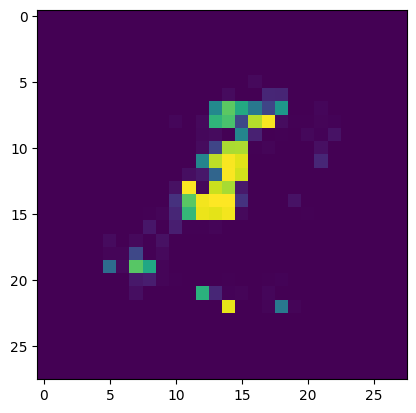

discriminator loss 0.6001979257218848 for 7/60
generator loss 1.2139533014117825 for 7/60


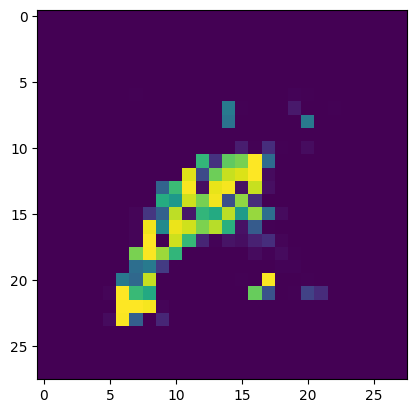

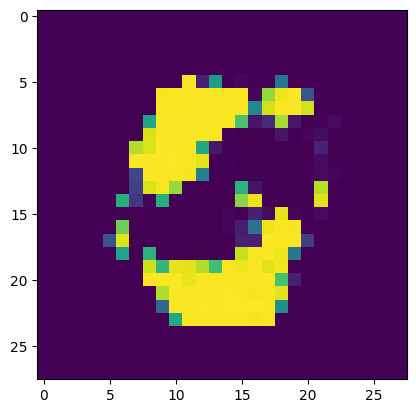

discriminator loss 0.6300102629968604 for 8/60
generator loss 1.0770206604201238 for 8/60


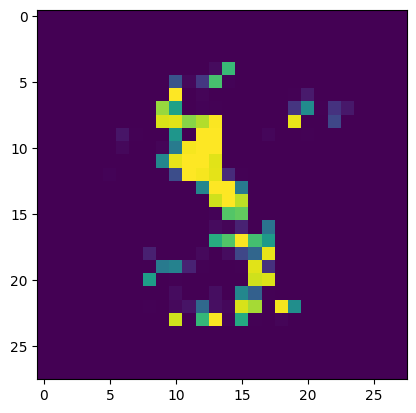

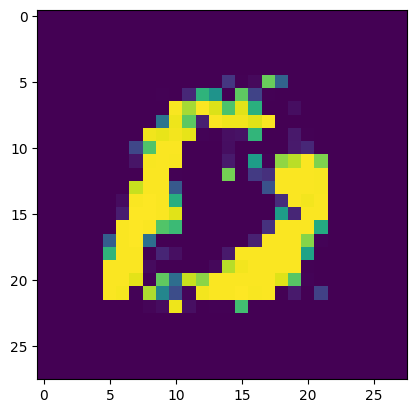

discriminator loss 0.6249590948030785 for 9/60
generator loss 1.1011225157604312 for 9/60


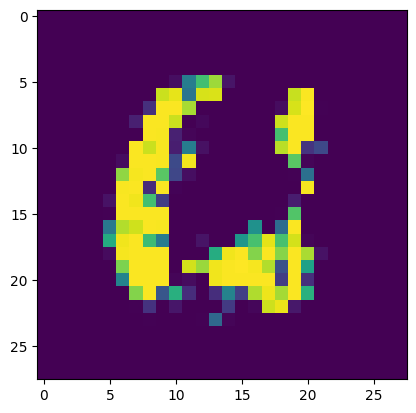

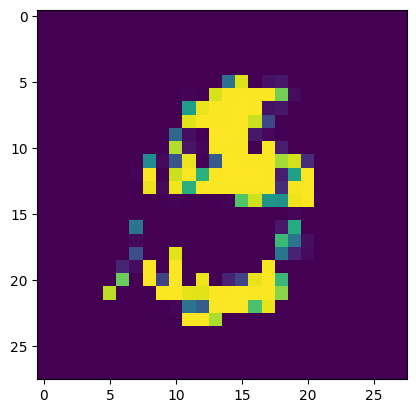

discriminator loss 0.6362227346055518 for 10/60
generator loss 1.0414886697344459 for 10/60


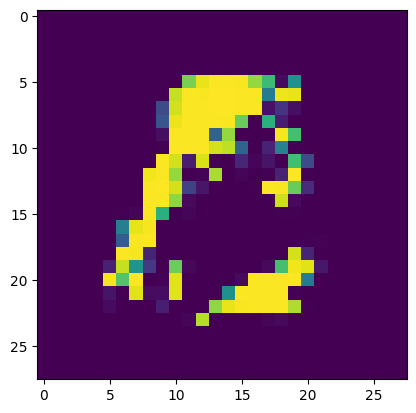

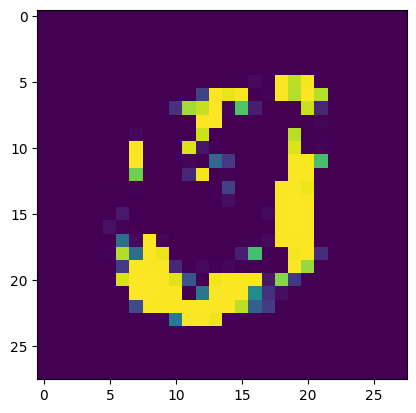

discriminator loss 0.6405579126068955 for 11/60
generator loss 1.0270230318014086 for 11/60


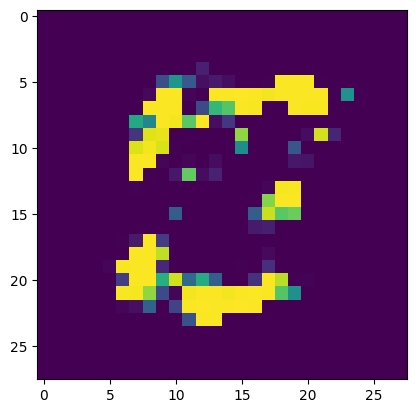

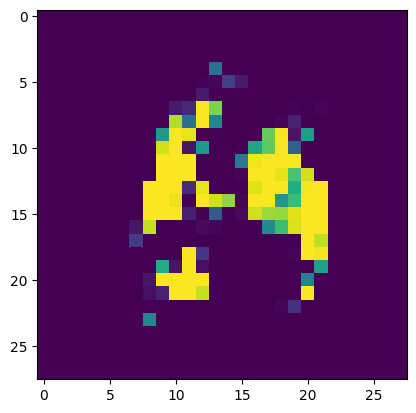

discriminator loss 0.6496483065082086 for 12/60
generator loss 0.9873616767746936 for 12/60


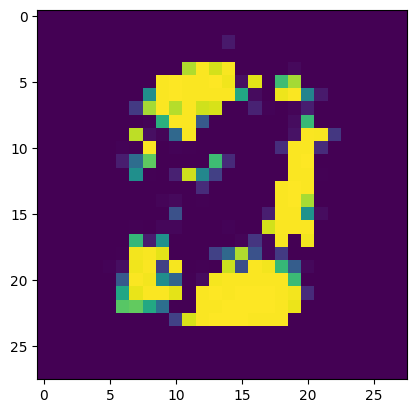

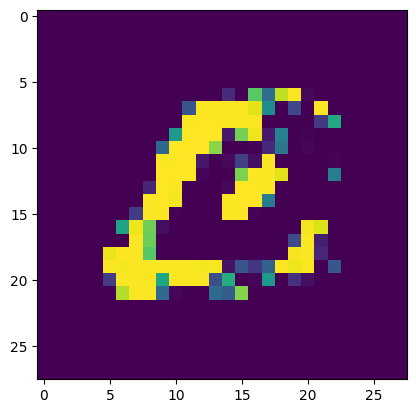

discriminator loss 0.6123876406168628 for 13/60
generator loss 1.161058187650412 for 13/60


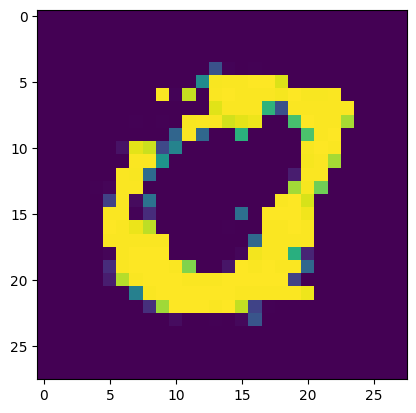

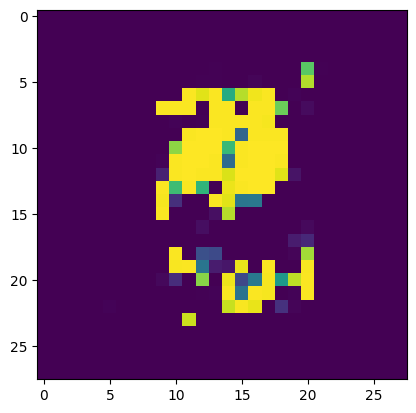

discriminator loss 0.6228993338077726 for 14/60
generator loss 1.1071921098077644 for 14/60


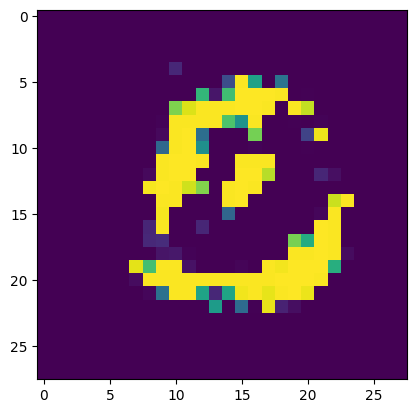

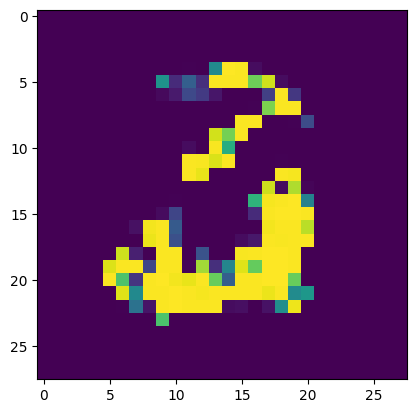

discriminator loss 0.6186285897251851 for 15/60
generator loss 1.1294866996720074 for 15/60


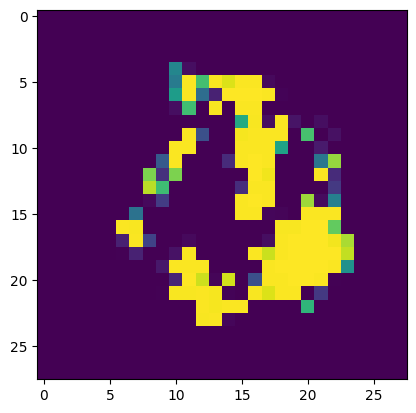

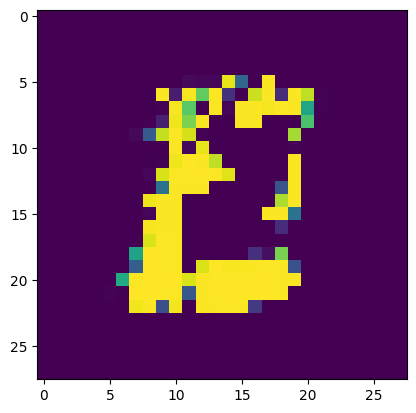

discriminator loss 0.6035218236897741 for 16/60
generator loss 1.1915499213450187 for 16/60


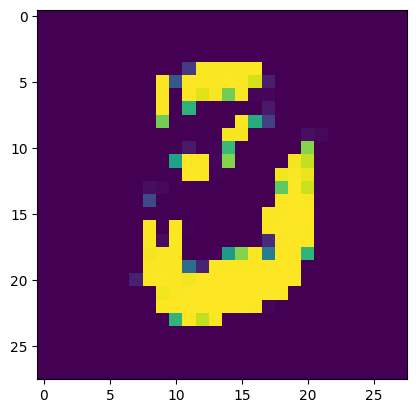

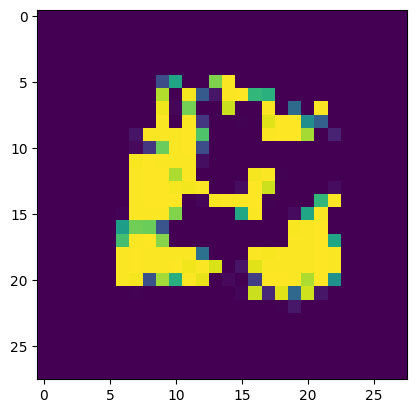

discriminator loss 0.6072072041778376 for 17/60
generator loss 1.1909153485570594 for 17/60


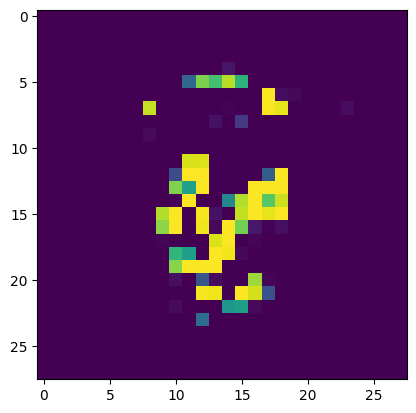

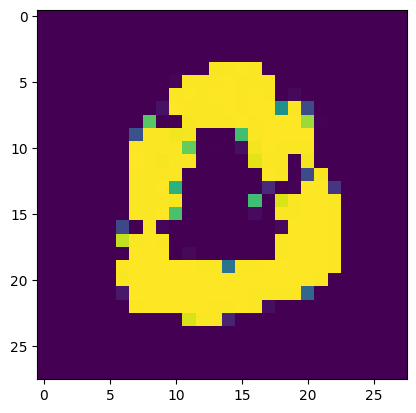

discriminator loss 0.602340820580813 for 18/60
generator loss 1.2165956922782064 for 18/60


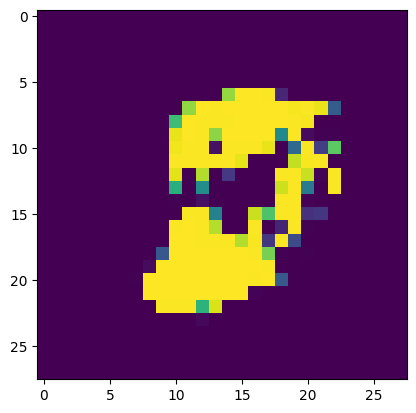

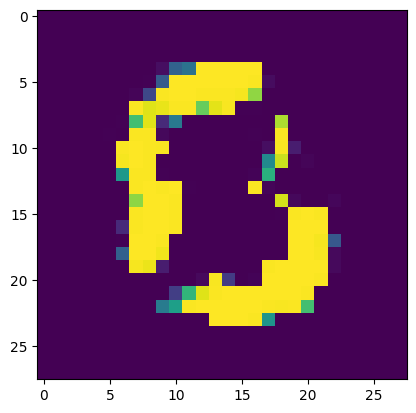

discriminator loss 0.6167018986212169 for 19/60
generator loss 1.1409998282817795 for 19/60


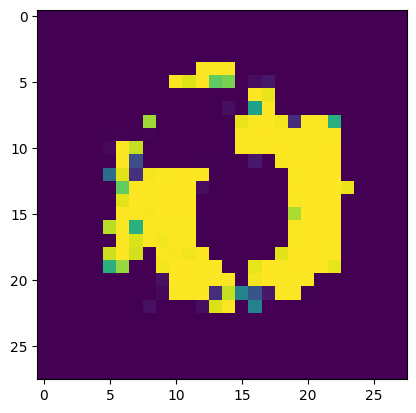

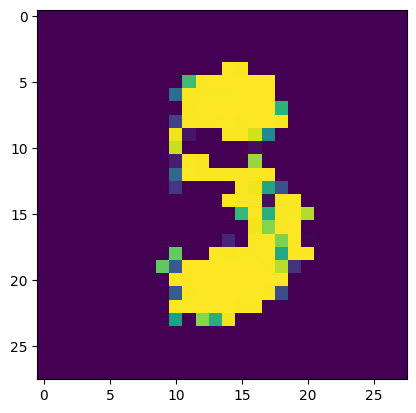

discriminator loss 0.5712167357426503 for 20/60
generator loss 1.3515816541679706 for 20/60


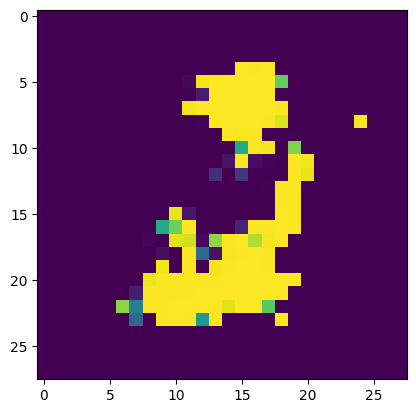

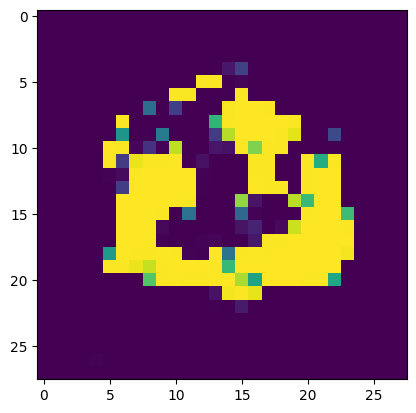

discriminator loss 0.5482219910551693 for 21/60
generator loss 1.4905477653800006 for 21/60


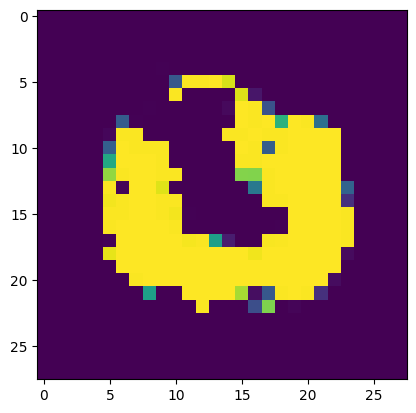

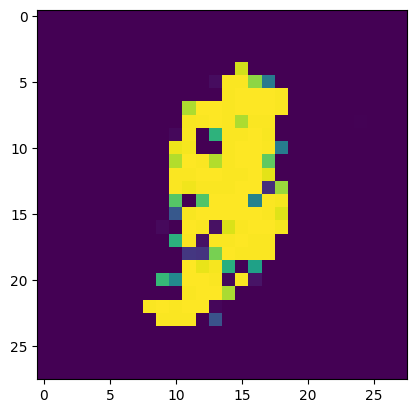

discriminator loss 0.5253236955831344 for 22/60
generator loss 1.6154031006733234 for 22/60


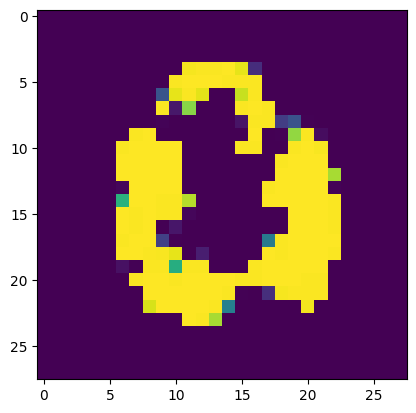

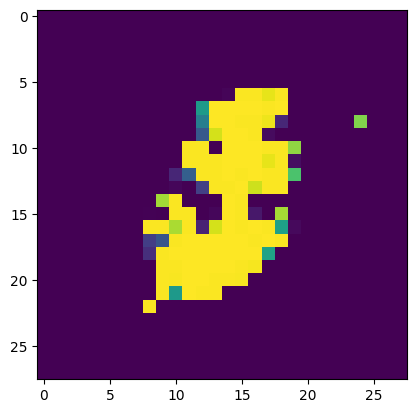

discriminator loss 0.5007896187443142 for 23/60
generator loss 1.7108802729510024 for 23/60


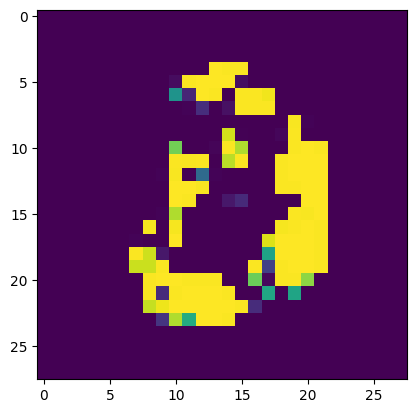

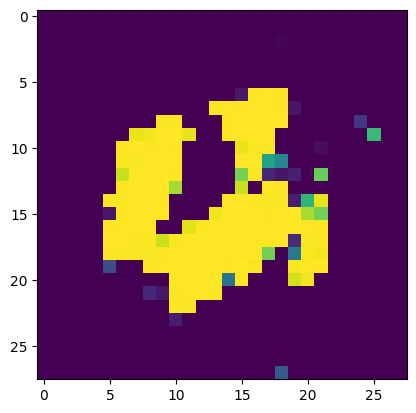

discriminator loss 0.5068805380652465 for 24/60
generator loss 1.7294621803717822 for 24/60


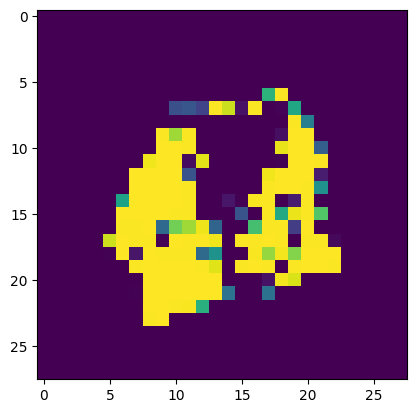

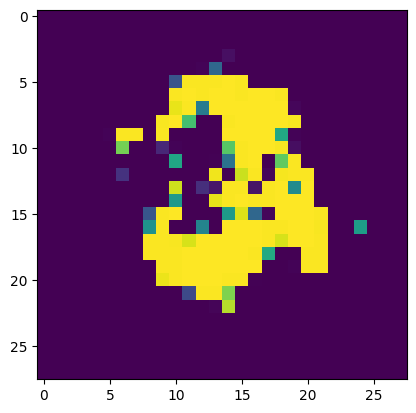

discriminator loss 0.5026191551516718 for 25/60
generator loss 1.7616844275544057 for 25/60


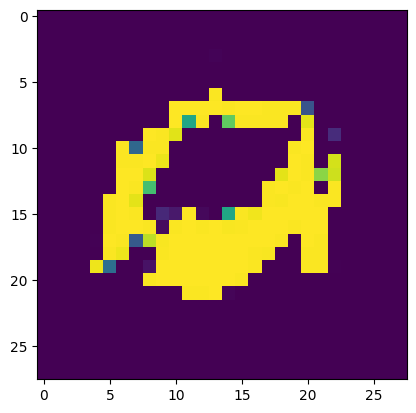

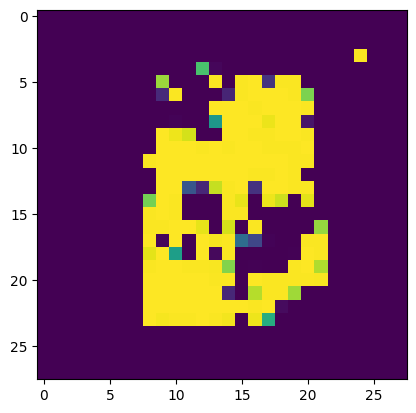

discriminator loss 0.5141265202518449 for 26/60
generator loss 1.6822725008710657 for 26/60


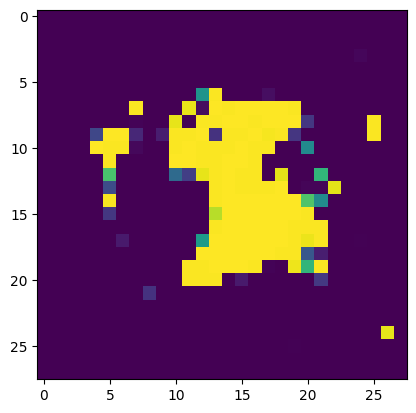

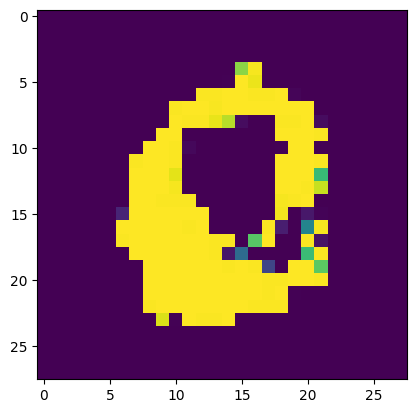

discriminator loss 0.5023118426322642 for 27/60
generator loss 1.7745394408334694 for 27/60


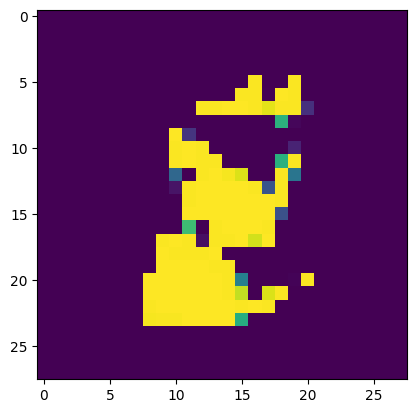

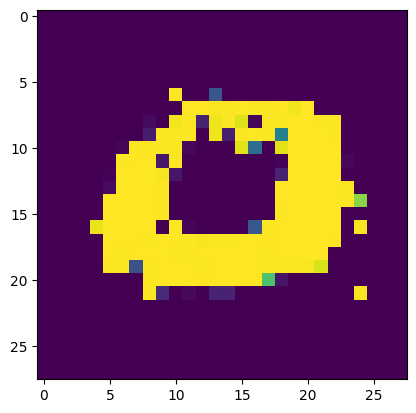

discriminator loss 0.4701714334736789 for 28/60
generator loss 1.9556678909810699 for 28/60


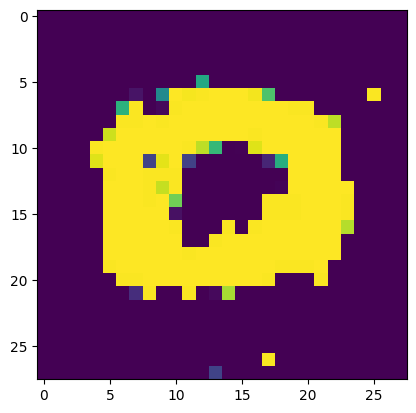

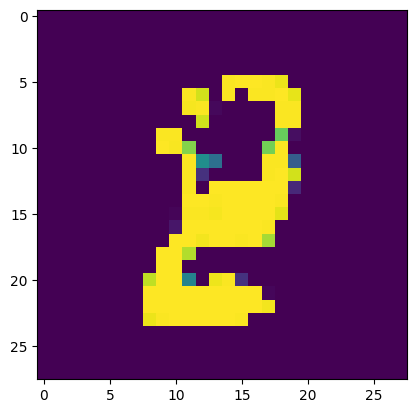

discriminator loss 0.40728742720408523 for 29/60
generator loss 2.435404351605833 for 29/60


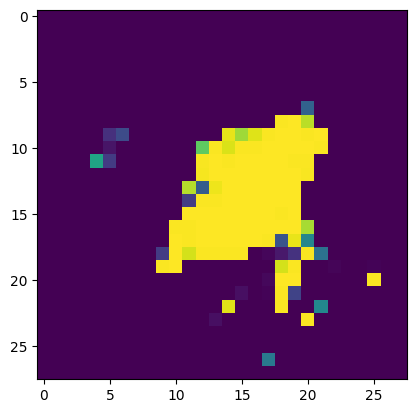

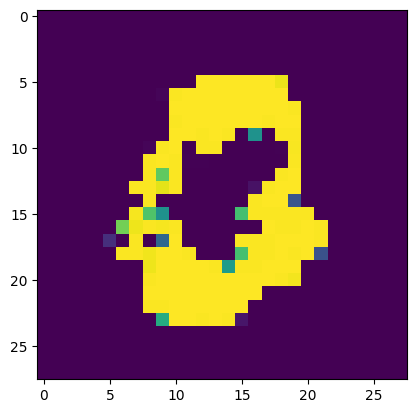

discriminator loss 0.4030716745269159 for 30/60
generator loss 2.396943315486248 for 30/60


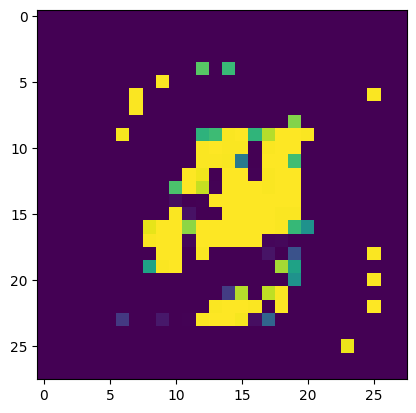

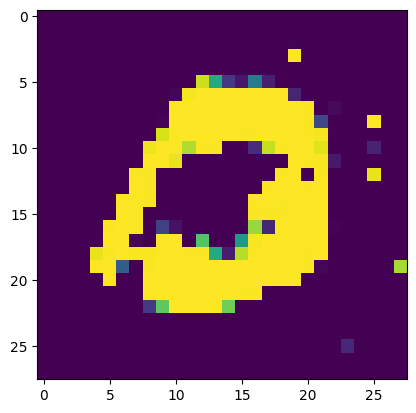

discriminator loss 0.44214434197392266 for 31/60
generator loss 2.2157130988753084 for 31/60


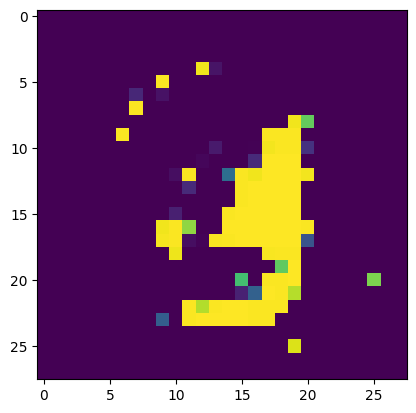

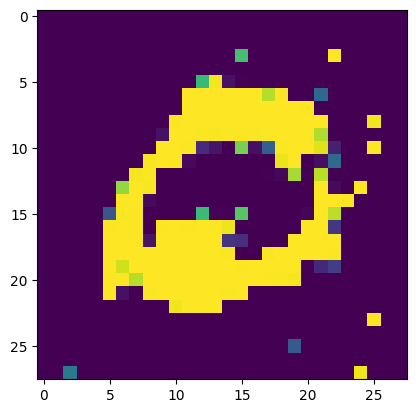

discriminator loss 0.4659953773058514 for 32/60
generator loss 2.083087921915708 for 32/60


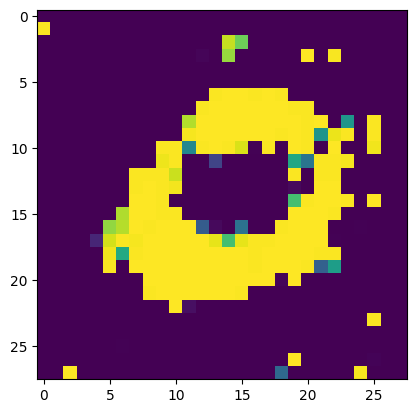

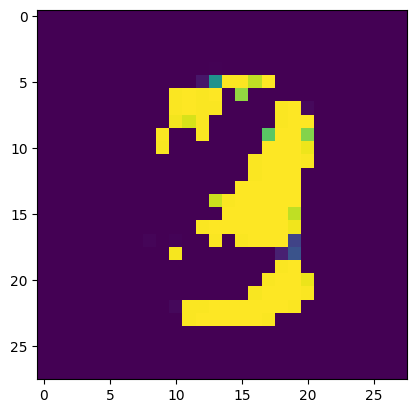

discriminator loss 0.3970501460111973 for 33/60
generator loss 2.4458851321675734 for 33/60


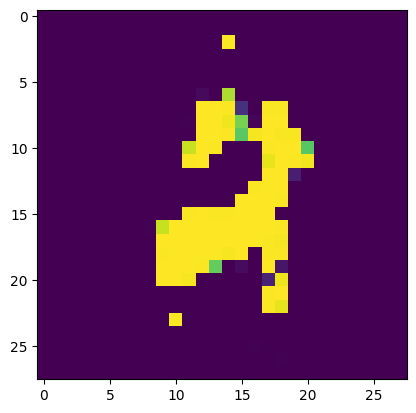

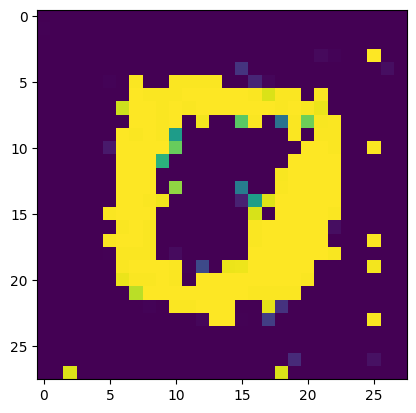

discriminator loss 0.36823602052954263 for 34/60
generator loss 2.682667749431709 for 34/60


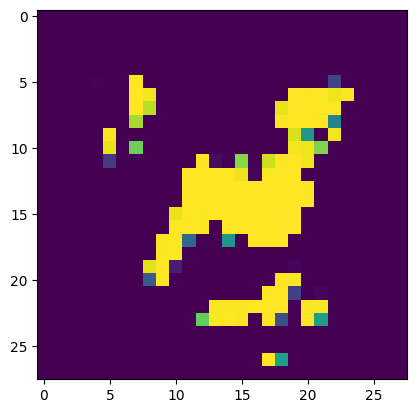

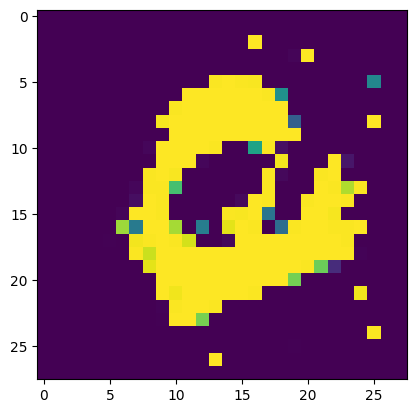

discriminator loss 0.4296971225559969 for 35/60
generator loss 2.317642636693798 for 35/60


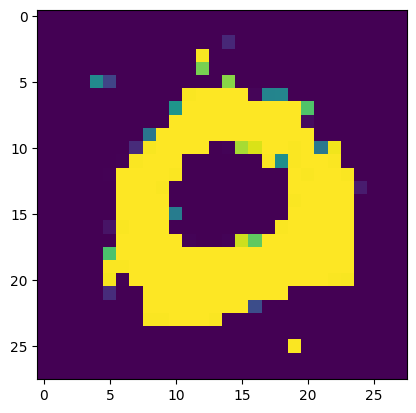

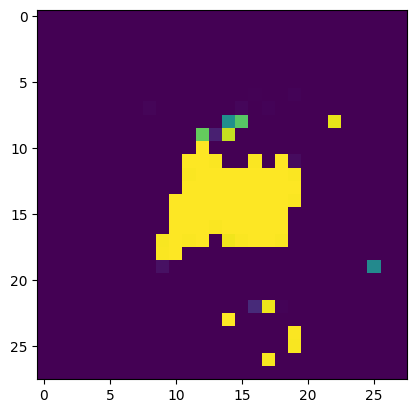

discriminator loss 0.3839998914548981 for 36/60
generator loss 2.577790932533106 for 36/60


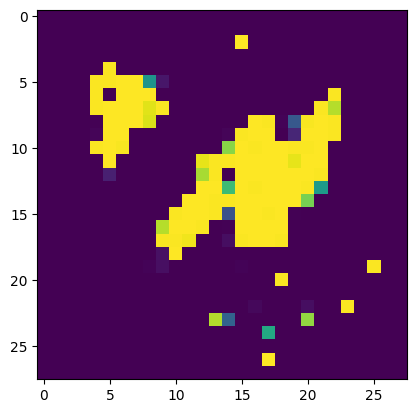

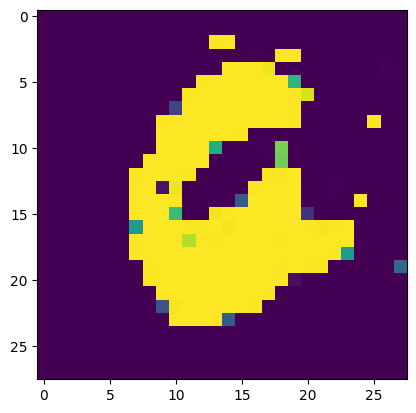

discriminator loss 0.3631327302966536 for 37/60
generator loss 2.7773432921597516 for 37/60


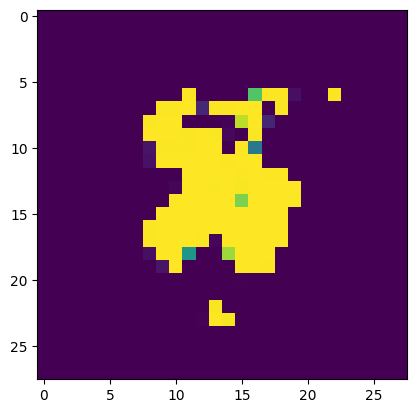

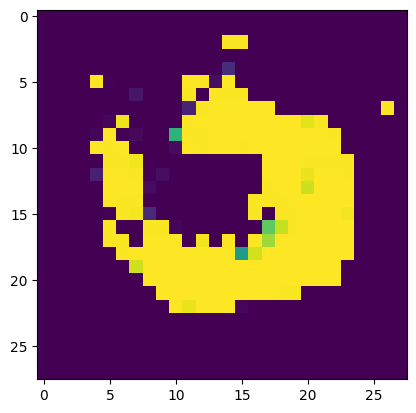

discriminator loss 0.35944599613151557 for 38/60
generator loss 2.814273621065518 for 38/60


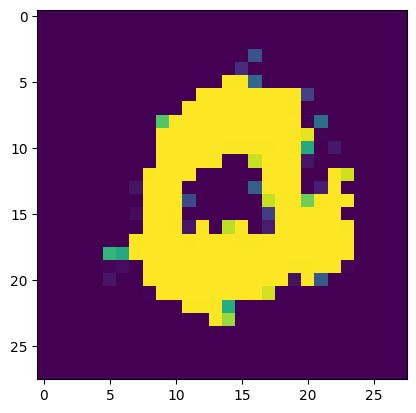

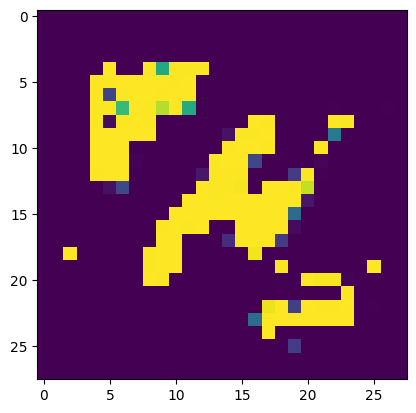

discriminator loss 0.4099865280565765 for 39/60
generator loss 2.4482170274921815 for 39/60


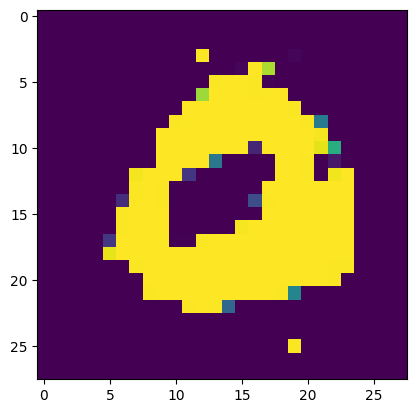

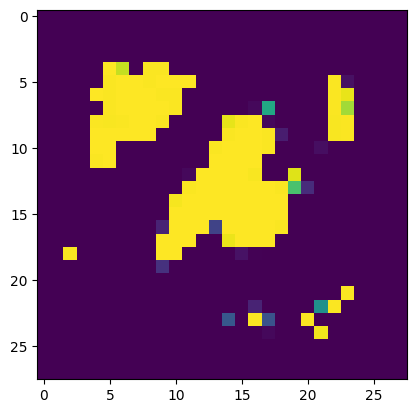

discriminator loss 0.37807170402919016 for 40/60
generator loss 2.690409192080259 for 40/60


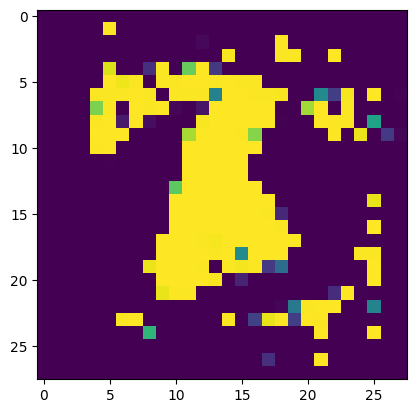

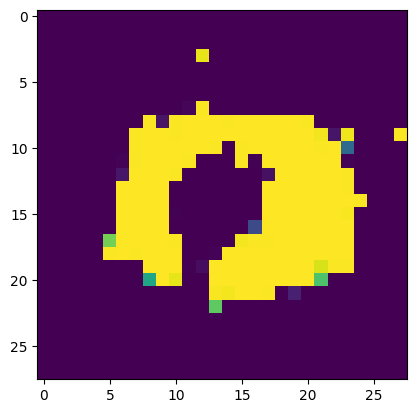

discriminator loss 0.355111362330887 for 41/60
generator loss 2.8248130786264287 for 41/60


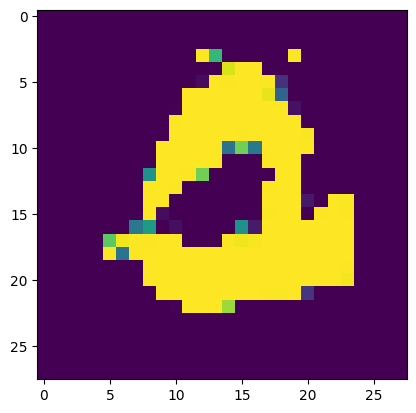

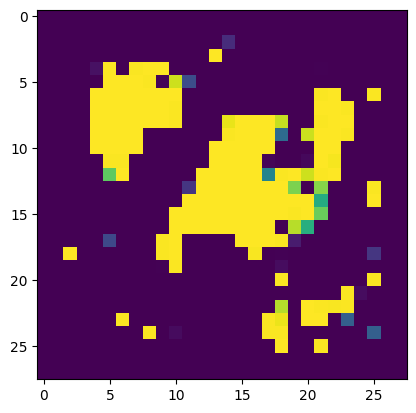

discriminator loss 0.406980000431704 for 42/60
generator loss 2.5138989102332365 for 42/60


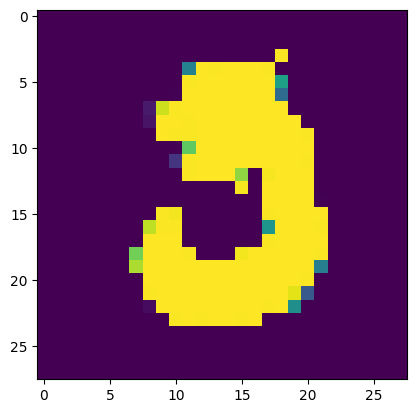

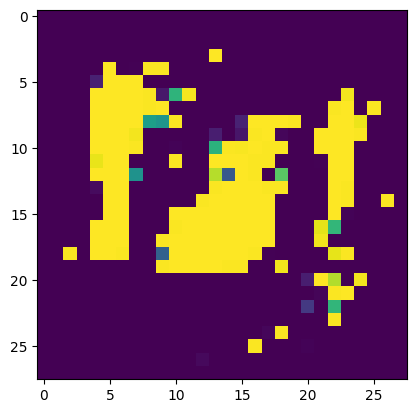

discriminator loss 0.3597409377510788 for 43/60
generator loss 2.7767898421032773 for 43/60


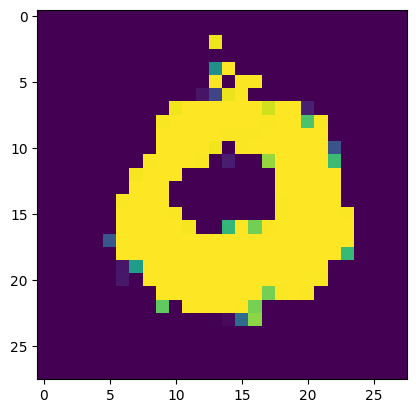

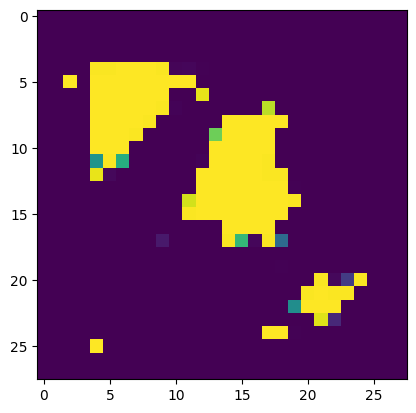

discriminator loss 0.3892512609969325 for 44/60
generator loss 2.6019396364063008 for 44/60


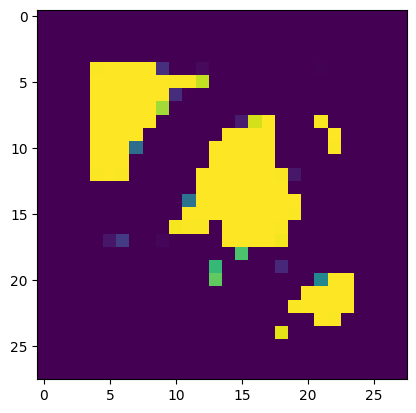

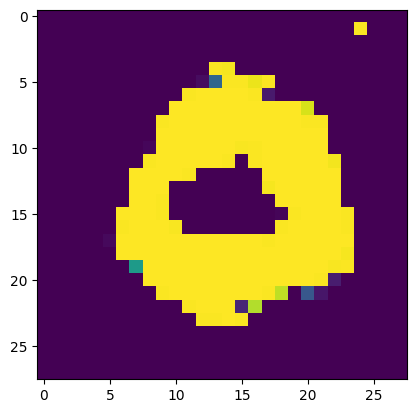

discriminator loss 0.398112776058187 for 45/60
generator loss 2.5317795876369864 for 45/60


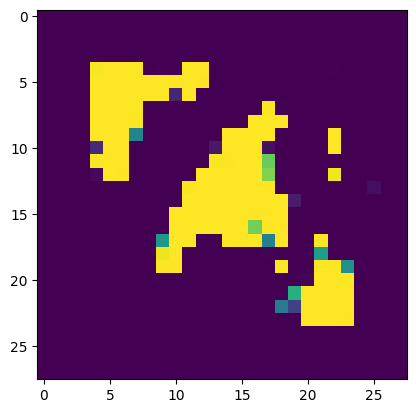

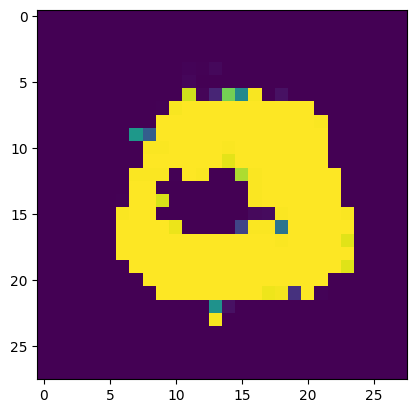

discriminator loss 0.3890027153990827 for 46/60
generator loss 2.6155565193658115 for 46/60


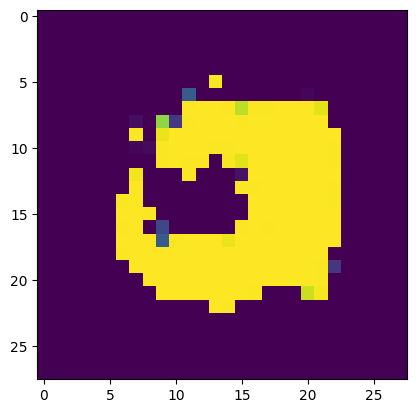

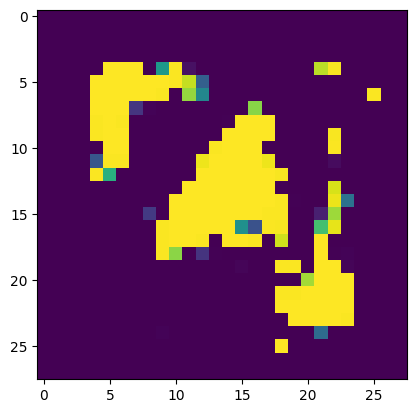

discriminator loss 0.41860138042758027 for 47/60
generator loss 2.367394292774283 for 47/60


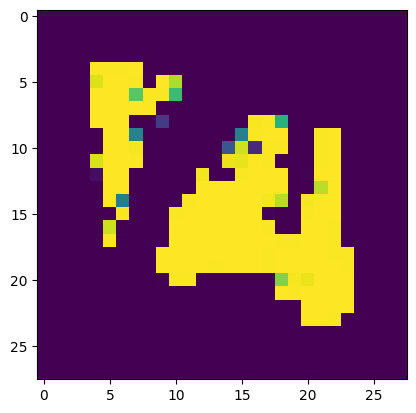

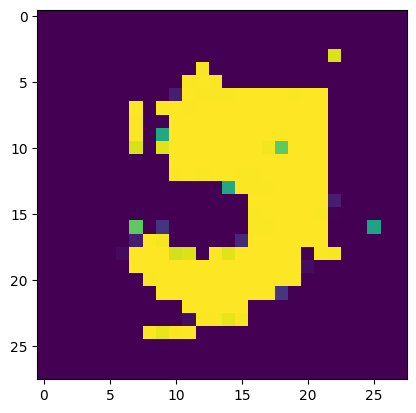

discriminator loss 0.4980720783123048 for 48/60
generator loss 1.8893623569263507 for 48/60


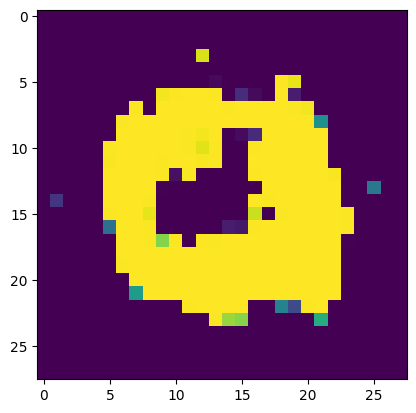

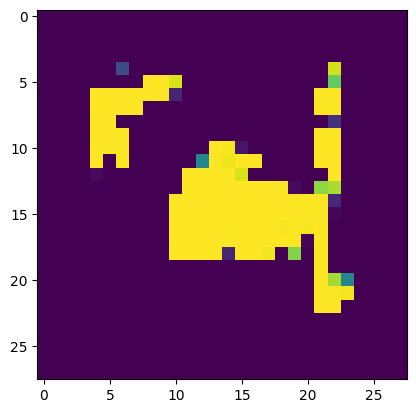

discriminator loss 0.5688659935508561 for 49/60
generator loss 1.4863632750813058 for 49/60


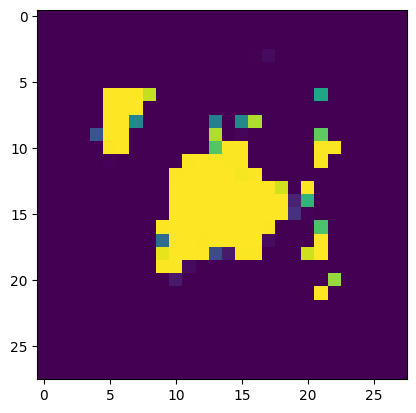

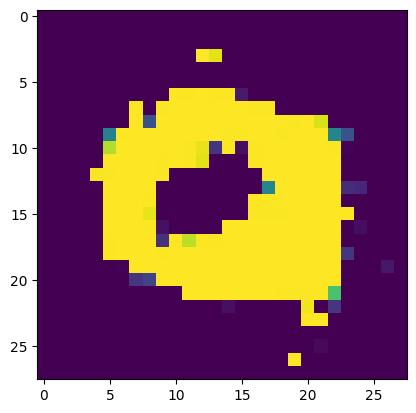

discriminator loss 0.5537208187094141 for 50/60
generator loss 1.5274564117616602 for 50/60


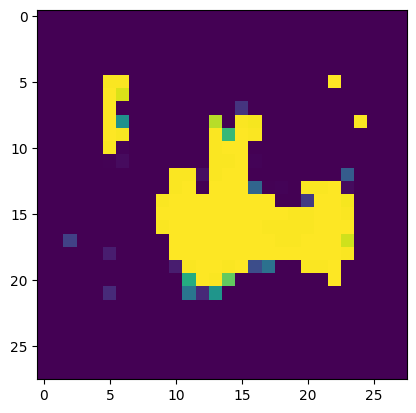

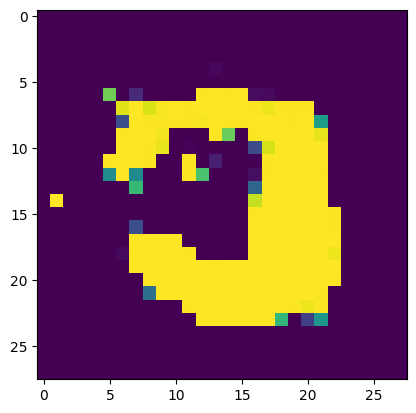

discriminator loss 0.6186212982713182 for 51/60
generator loss 1.2502966404255706 for 51/60


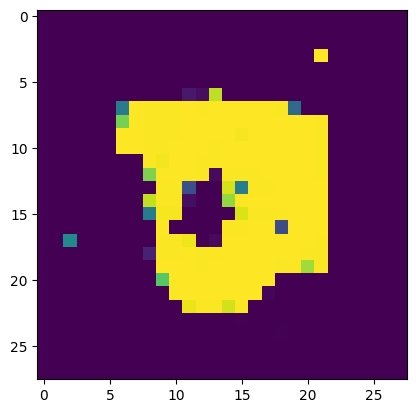

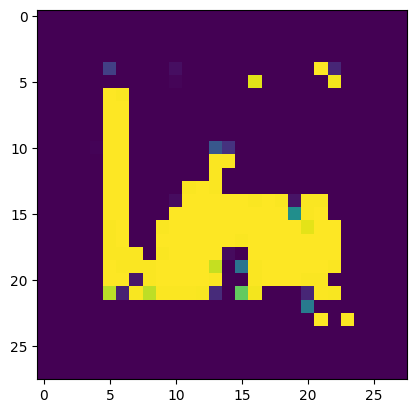

discriminator loss 0.6286535820451469 for 52/60
generator loss 1.1554861316311278 for 52/60


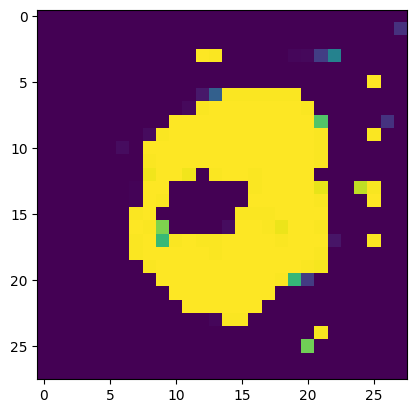

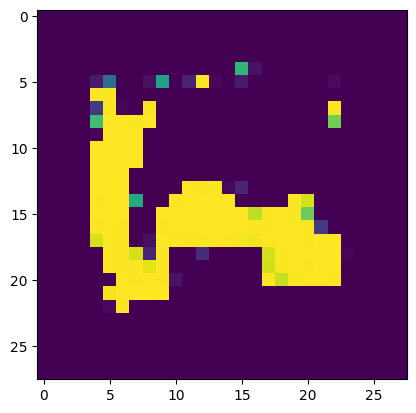

discriminator loss 0.6542043651766509 for 53/60
generator loss 1.0548609277029843 for 53/60


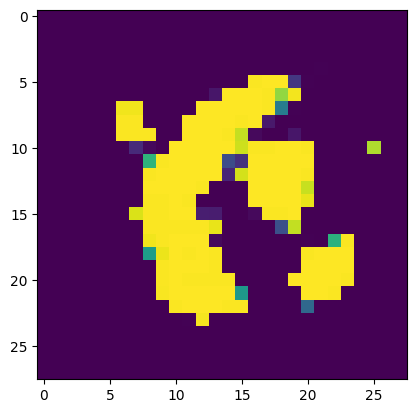

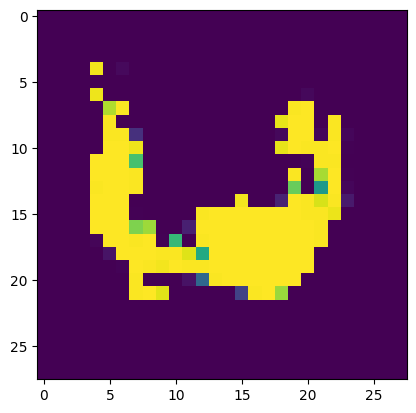

discriminator loss 0.6512977426585185 for 54/60
generator loss 1.0230287678305052 for 54/60


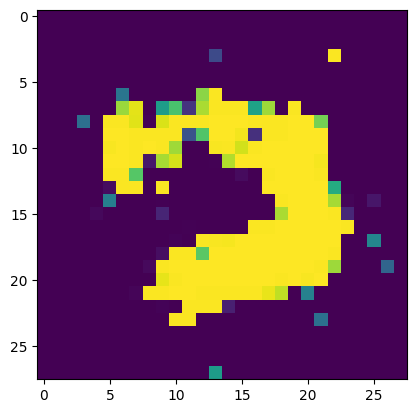

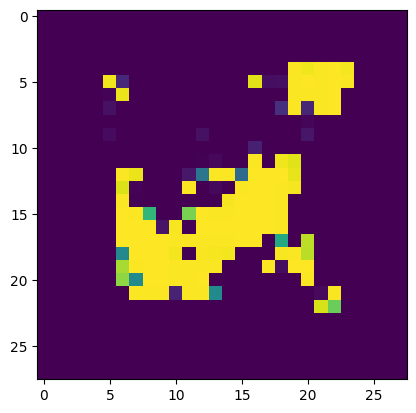

discriminator loss 0.6576360317661557 for 55/60
generator loss 1.0063649680306692 for 55/60


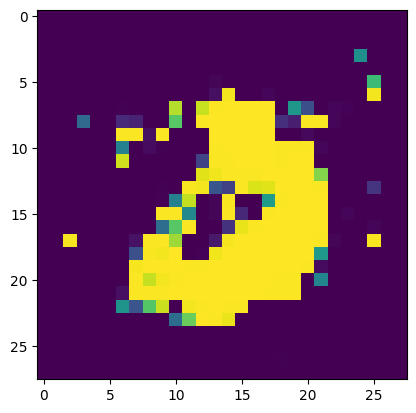

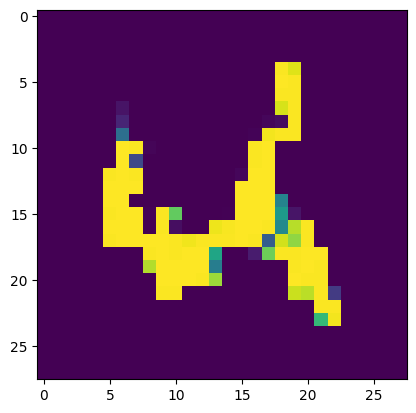

discriminator loss 0.6652204775751337 for 56/60
generator loss 0.9684684485878158 for 56/60


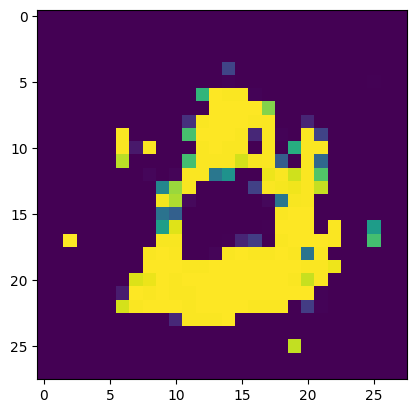

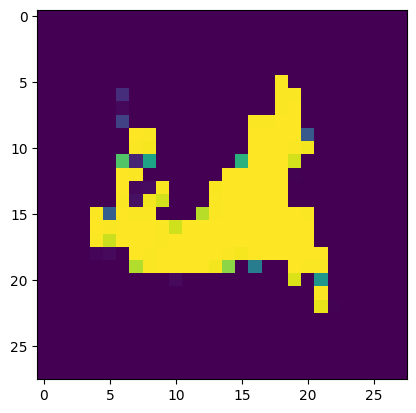

discriminator loss 0.6696035414842119 for 57/60
generator loss 0.9343446892415248 for 57/60


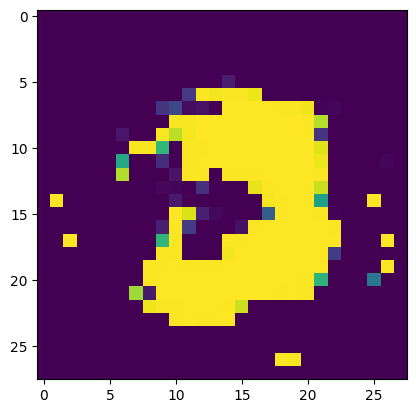

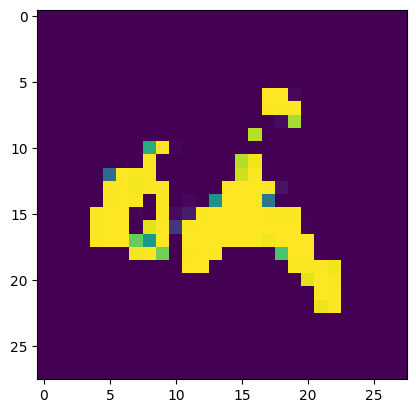

discriminator loss 0.6702765228389 for 58/60
generator loss 0.925024748069405 for 58/60


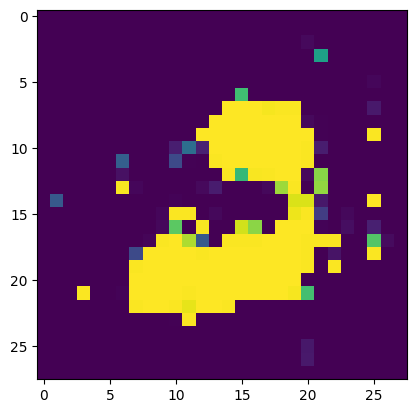

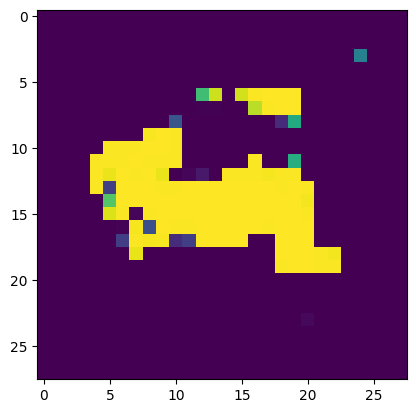

discriminator loss 0.6791120192347816 for 59/60
generator loss 0.8837173849509924 for 59/60


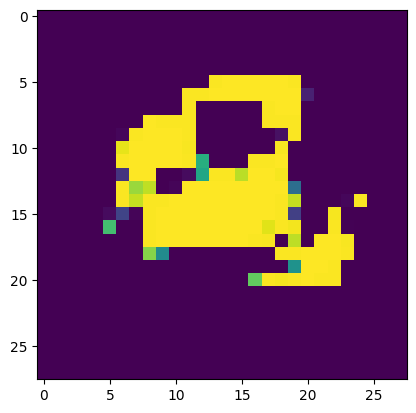

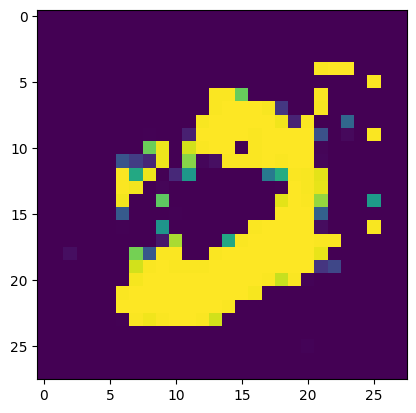

discriminator loss 0.665844804549232 for 60/60
generator loss 0.9178894048969711 for 60/60


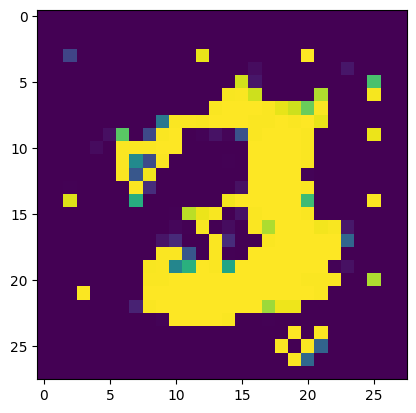

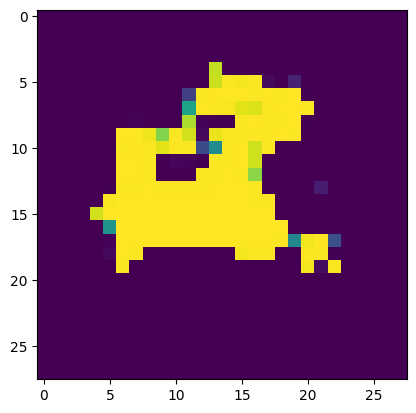

In [35]:
for epoch in range(n_epochs):
    generator_loss=0
    discriminator_loss=0
    for data in char_loader:
        #setting gradient of discriminator at zero
        disc_optimizer.zero_grad()
        
        #getting real data
        real_images,classes=data[0].to(device),data[1].to(device)
        real_images=real_images.float()
        reshape_layer1=nn.Linear(36,28)
        reshape_layer1=reshape_layer1.to(device)
        reshape_layer2=nn.Unflatten(1,(1,28,1)) #because the image has (1,28,28) shape
        reshape_layer2=reshape_layer2.to(device)
        #print(classes.size())
        #print(reshape_layer2(reshape_layer1(classes.float())).size())
        #print(real_images.size())
        classes_reshape=reshape_layer2(reshape_layer1(classes.float()))
        real_images_classes=torch.cat((real_images,classes_reshape),3)
        real_labels1=torch.ones((real_images.shape[0]-int(real_images.shape[0]*0.1),1)) #we choose 0 to get the batch size and this means that this images are real
        real_labels2=torch.zeros((int(real_images.shape[0]*0.1),1))
        real_labels=torch.cat((real_labels1,real_labels2),0) #to trick the generator
                                 
        real_labels=real_labels.to(device)
        #getting fake data
        noise=torch.rand((real_images.shape[0],100))
        noise=noise.float()
        noise=noise.to(device)
        noise_with_class=torch.cat((noise,classes.float()),1)
        fake_images=generator(noise_with_class)#.detach()
        #print("size of fake images ",fake_images.size())
        fake_images_classes=torch.cat((fake_images,classes_reshape),3)
        fake_labels=torch.zeros((real_images.shape[0],1))
        #fake_labels1=torch.zeros((real_images.shape[0]-int(real_images.shape[0]*0.1),1))
        #fake_labels2=torch.ones((int(real_images.shape[0]*0.1),1))
        #fake_labels=torch.cat((fake_labels1,fake_labels2),0) #to trick the discriminator
        fake_labels=fake_labels.to(device)
        #merging the fake and real data
        data=torch.cat((real_images_classes,fake_images_classes),0)
        #print("size of data ",data.shape)
        labels=torch.cat((real_labels,fake_labels),0)
        #predicting class
        pred=discriminator(data)
        #calculating L1 and L2 term
        #L1_term=torch.tensor(0.,requires_grad=True)
        #L2_term=torch.tensor(0.,requires_grad=True)
        #nweights=0
        #for name,weights in model.named_parameters():
        #    if 'bias' not in name:
        #        l1_weights_sum=torch.sum(torch.abs(weights))
        #        l2_weights_sum=torch.sum(torch.square(weights))
        #       L1_term=L1_term+l1_weights_sum
        #        L2_term=L2_term+l2_weights_sum
        #        nweights+=weights.numel()
        #L1_term=L1_term/ nweights
        #L2_term=L2_term/ nweights
        #disc loss
        disc_loss=criterion(pred,labels)
        #loss=loss+L1_term*l1_lambda# +L2_term*l2_lambda #regularizing loss
        disc_loss.backward(retain_graph=True)
        #updating discriminator params
        disc_optimizer.step()
        discriminator_loss += disc_loss.item()
        #setting gradiant of generator at zero
        gen_optimizer.zero_grad()
        #generator loss
        pred=discriminator(fake_images_classes)
        labels=torch.ones((real_images.shape[0],1))
        labels=labels.to(device)
        gen_loss=criterion(pred,labels)
        gen_loss.backward()
        #updating generator params
        gen_optimizer.step()
        generator_loss += gen_loss.item()
    epoch_disc_loss = discriminator_loss / len(char_loader)
    epoch_gen_loss = generator_loss / len(char_loader)
    print(f'discriminator loss {epoch_disc_loss} for {epoch+1}/{n_epochs}')
    print(f'generator loss {epoch_gen_loss} for {epoch+1}/{n_epochs}')
    #testing generated images
    noise=np.random.randn(2,100)
    images_class=encoder.transform([[0],[23]]).toarray()
    images_array=generator(torch.from_numpy(np.concatenate((noise,images_class),axis=1)).float().to(device)).detach().to('cpu').numpy()
    i=0 #is the index of current image
    for image in images_array:
        image=image.reshape((28,28))*255
        image=image.astype('uint8')
        raw_image=Image.fromarray(image)
        raw_image.save("image"+str(i)+"_epoch_"+str(epoch+1)+".png")
        i+=1
        plt.imshow(image)
        plt.show()
    #train_l.append(epoch_loss)

In [36]:
generator.state_dict()
data={"generator_dict":generator.state_dict(),"discriminator_dict":discriminator.state_dict}
torch.save(data,"data.pth")